# This nb is to prototype and compare probes


In [ ]:
import os
os.environ['TQDM_DISABLE'] = '1'


In [ ]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

plt.style.use("ggplot")

from typing import Optional, List, Dict, Union
from jaxtyping import Float
from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path
from einops import rearrange


import datasets
from datasets import Dataset

from loguru import logger

logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")

# # quiet please
torch.set_float32_matmul_precision("medium")
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")


In [ ]:
# load my code
%load_ext autoreload
%autoreload 2

import lightning.pytorch as pl
from src.datasets.dm import DeceptionDataModule
from src.models.pl_lora_ft import AtapterFinetuner

from src.config import ExtractConfig
from src.prompts.prompt_loading import load_preproc_dataset, load_preproc_datasets
from src.models.load import load_model
from src.helpers.torch_helpers import clear_mem
from src.models.phi.model_phi import PhiForCausalLMWHS


# Load previously made datasets of hidden states

In [ ]:
!ls -altrh '/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/'

!ls -altrh '/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_valtest_8c031b4aa03ae4d2'


In [ ]:
f1_ood = '/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_OOD_2fd327cd848febaa'
f1_val = '/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_valtest_e0e88587bc697ddf'


In [ ]:
ds_val = Dataset.from_file(f1_val).with_format("torch")

ds_oos = Dataset.from_file(f1_ood).with_format("torch")

ds_out = datasets.interleave_datasets([ds_val, ds_val])

ds_out


# Probes




In [ ]:
max_epochs = 160
batch_size=16
verbose = False


In [ ]:
from src.eval.interventions import check_lr_intervention_predictive
from src.eval.labels import ranking_truth_telling
from src.eval.ds import filter_ds_to_known

from src.models.pl_ranking_probe import PLConvProbeLinear
from src.helpers.lightning import read_metrics_csv
from sklearn.metrics import roc_auc_score
from src.helpers.pandas_classification_report import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset


## Linear

In [ ]:

ds_known = filter_ds_to_known(ds_out, verbose=True)
hs_normal = ds_out['end_residual_stream_base']
hs_intervene = ds_out['end_residual_stream_adapt']
label_fn = ranking_truth_telling
hs = hs_normal - hs_intervene
y = label_fn(ds_out)




In [28]:
check_lr_intervention_predictive(hs, y, verbose=True)


          0         1
0  0.950690  0.049310
1  0.167247  0.832753
              precision  recall  f1-score  support
0                  0.95    0.95      0.95     1014
1                  0.83    0.83      0.83      287
accuracy           0.92    0.92      0.92     1301
macro avg          0.89    0.89      0.89     1301
weighted avg       0.92    0.92      0.92     1301


0.9551093059535838

# Conv mse ranking

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=160` reached.


<Axes: xlabel='epoch'>

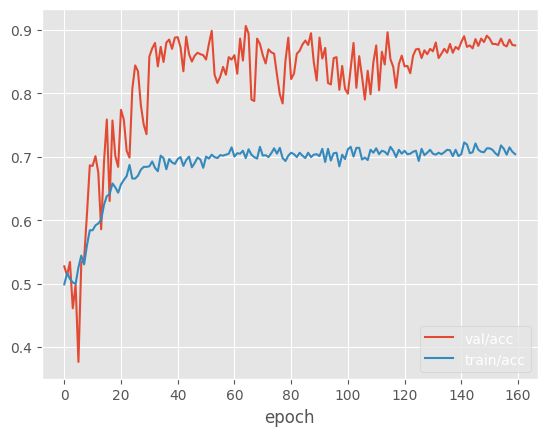

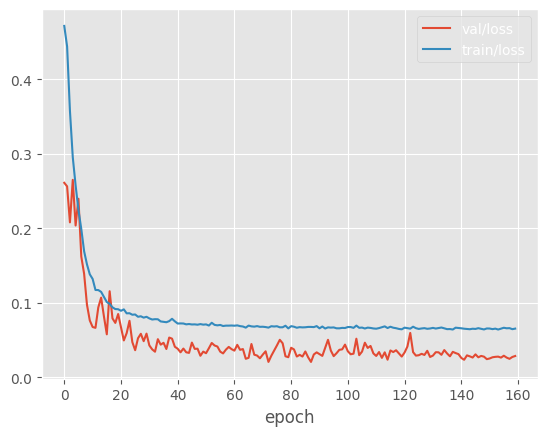

In [29]:
# def check_convrank_intervention_predictive(hs, y, verbose=True):


def ranking_truth_telling(ds):
    """label whether the adapter or the base model were more truthfull."""
    return ds['correct_truth_telling_adapt'] - ds['correct_truth_telling_base']

y = ranking_truth_telling(ds_out)
X = torch.stack([hs_normal,hs_intervene], 1)
X_train0, X_val0, X_train1, X_val1, y_train, y_val = train_test_split(hs_normal, hs_intervene, y, test_size=0.5, random_state=42)

to_ds = lambda hs0, hs1, y: TensorDataset(hs0, hs1, y)
dl_train = DataLoader(to_ds(X_train0, X_train1, y_train), batch_size=batch_size, shuffle=True)
dl_val = DataLoader(to_ds(X_val0, X_val1, y_val), batch_size=batch_size, shuffle=False)

x0, x1,y1 = next(iter(dl_train))
c_in = x1.shape[1:]
net = PLConvProbeLinear(c_in, total_steps=max_epochs * len(dl_train), depth=3, lr=4e-3, weight_decay=1e-5, hs=32, dropout=0.1)

from torchinfo import summary
summary(net, input_data=x1) # input_size=(batch_size, 1, 28, 28))


trainer1 = pl.Trainer(
    gradient_clip_val=20,
    # accelerator="auto",
    # devices="1",
    max_epochs=max_epochs,
    log_every_n_steps=1,
    enable_progress_bar=verbose,
      enable_model_summary=verbose
)
trainer1.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val);

df_hist, df_hist_step  = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)

df_hist[['val/acc', 'train/acc']].plot()
df_hist[['val/loss', 'train/loss']].plot()
# df_hist_step[['val/acc', 'train/acc']].plot(style=".")
# df_hist_step[['val/loss', 'train/loss']].plot(style=".")


In [30]:

r = trainer1.predict(net, dataloaders=dl_val)
y_pred_raw = torch.cat(r).flatten()
# y_pred_prob = (y_pred_raw+1)/2
y_pred_prob = (torch.tanh(y_pred_raw)+1)/2
y_pred = y_pred_prob > 0.5

score = roc_auc_score(y_val>0, y_pred_prob)
print(score)
# if verbose:
target_names = [0, 1]
cm = confusion_matrix(y_val>0, y_pred, target_names=target_names, normalize='true')
cr = classification_report(y_val>0, y_pred, target_names=target_names)
print(cm)
print(cr)

# return score


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


0.5268559870226104
          0         1
0  0.505988  0.494012
1  0.481605  0.518395
              precision  recall  f1-score  support
0                  0.78    0.51      0.61     1002
1                  0.24    0.52      0.33      299
accuracy           0.51    0.51      0.51     1301
macro avg          0.51    0.51      0.47     1301
weighted avg       0.65    0.51      0.55     1301


# Conv bool ranking

In [31]:
from torchmetrics.functional import accuracy, auroc, f1_score, jaccard_index, dice
from random import random as rand

class PLConvProbeBoolRank(PLConvProbeLinear):
    def _step(self, batch, batch_idx, stage='train'):
        x0, x1, y = batch

        if rand()>0.5:
            x0, x1 = x1, x0
            y = -y
            
        ypred0 = self(x0)
        ypred1 = self(x1)
        
        if stage=='pred':
            return (ypred1-ypred0).float()
        
        ranking_y = (y>0)*2-1 # from 0,1 to -1,1
        loss = F.margin_ranking_loss(ypred1, ypred0, ranking_y, margin=1)
        # loss = F.smooth_l1_loss(ypred1-ypred0, y)
        # self.log(f"{stage}/loss", loss)
        
        y_cls = ypred1>ypred0 # switch2bool(ypred1-ypred0)
        self.log(f"{stage}/acc", accuracy(y_cls, y>0, "binary"), on_epoch=True, on_step=False)
        self.log(f"{stage}/loss", loss, on_epoch=True, on_step=False)
        self.log(f"{stage}/n", len(y), on_epoch=True, on_step=False, reduce_fx=torch.sum)
        return loss


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=160` reached.


<Axes: xlabel='epoch'>

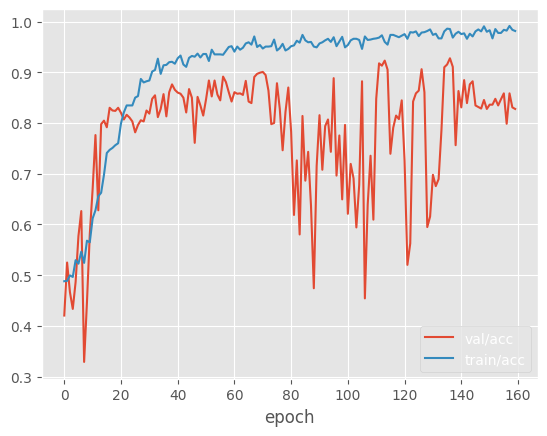

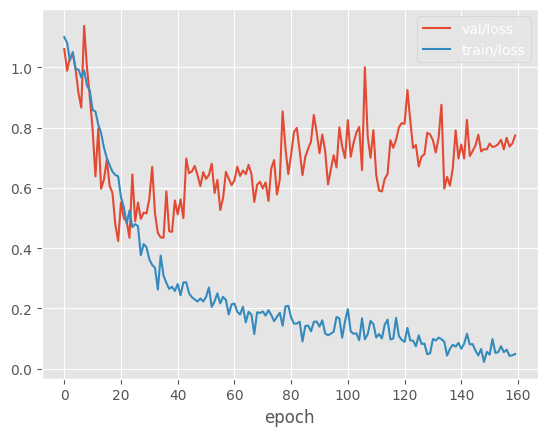

In [32]:


# def check_convrank_intervention_predictive(hs, y, verbose=True):


def ranking_truth_telling(ds):
    """label whether the adapter or the base model were more truthfull."""
    return ds['correct_truth_telling_adapt'] - ds['correct_truth_telling_base']

y = ranking_truth_telling(ds_out)
X = torch.stack([hs_normal,hs_intervene], 1)
X_train0, X_val0, X_train1, X_val1, y_train, y_val = train_test_split(hs_normal, hs_intervene, y, test_size=0.5, random_state=42)

to_ds = lambda hs0, hs1, y: TensorDataset(hs0, hs1, y)
dl_train = DataLoader(to_ds(X_train0, X_train1, y_train), batch_size=batch_size, shuffle=True)
dl_val = DataLoader(to_ds(X_val0, X_val1, y_val), batch_size=batch_size, shuffle=False)

x0, x1,y1 = next(iter(dl_train))
c_in = x1.shape[1:]
net = PLConvProbeBoolRank(c_in, total_steps=max_epochs * len(dl_train), depth=3, lr=4e-3, weight_decay=1e-5, hs=16, dropout=0.2)

from torchinfo import summary
summary(net, input_data=x1) # input_size=(batch_size, 1, 28, 28))


trainer1 = pl.Trainer(
    gradient_clip_val=20,
    # accelerator="auto",
    # devices="1",
    max_epochs=max_epochs,
    log_every_n_steps=1,
    enable_progress_bar=verbose,
      enable_model_summary=verbose
)
trainer1.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val);



df_hist, df_hist_step  = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)

df_hist[['val/acc', 'train/acc']].plot()
df_hist[['val/loss', 'train/loss']].plot()
# df_hist_step[['val/acc', 'train/acc']].plot(style=".")
# df_hist_step[['val/loss', 'train/loss']].plot(style=".")


In [33]:
r = trainer1.predict(net, dataloaders=dl_val)
y_pred_raw = torch.cat(r).flatten()
y_pred_prob = (torch.tanh(y_pred_raw)+1)/2
y_pred = y_pred_prob > 0.5

score = roc_auc_score(y_val>0, y_pred_prob)
print(score)
target_names = [0, 1]
cm = confusion_matrix(y_val>0, y_pred, target_names=target_names, normalize='true')
cr = classification_report(y_val>0, y_pred, target_names=target_names)
print(cm)
print(cr)

# return score


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


0.5906648241977583
          0         1
0  0.537924  0.462076
1  0.414716  0.585284
              precision  recall  f1-score  support
0                  0.81    0.54      0.65     1002
1                  0.27    0.59      0.37      299
accuracy           0.55    0.55      0.55     1301
macro avg          0.54    0.56      0.51     1301
weighted avg       0.69    0.55      0.58     1301


# Conv direct


In [34]:
from torchmetrics.functional import accuracy, auroc, f1_score, jaccard_index, dice
from src.models.pl_ranking_probe import LinBnDrop, InceptionBlock, PLRankingBase

class PLConvProbeLinearCls(PLRankingBase):

    def __init__(self, c_in, total_steps, depth=0, lr=4e-3, weight_decay=1e-9, hs=8, dropout=0, **kwargs):
        super().__init__(total_steps=total_steps, lr=lr, weight_decay=weight_decay)
        self.save_hyperparameters()
        
        
        self.pre = nn.Sequential(
            # nn.BatchNorm2d(c_in[1], affine=False),
            nn.Conv2d(c_in[1], hs*4, (1, 2)),
            nn.Conv2d(hs*4, hs*4, (2, 1)),
        )

        layers = [
            nn.BatchNorm1d(hs*4, affine=False)
            ]
        for i in range(depth+1):
            if (i>0) and (i<depth):
                layers.append(InceptionBlock(hs*4, hs, conv_dropout=dropout))
            elif i==0: # first layer
                if depth==0: 
                    layers.append(InceptionBlock(hs*4, 1))
                else:
                    layers.append(InceptionBlock(hs*4, hs, conv_dropout=dropout))
            else: # last layer
                layers.append(nn.Conv1d(hs*4, 1, 1))
        self.conv = nn.Sequential(*layers)
        
        n = c_in[0] - 1
        self.head = nn.Sequential(
            LinBnDrop(n, n, p=dropout),
            LinBnDrop(n, n, p=dropout),
            nn.Linear(n, 1),  
            # nn.Tanh(), 
        )
        
    def forward(self, x):
        if x.ndim==4:
            x = x.squeeze(3)
        x = rearrange(x, 'b l h n -> b h l n')
        x = self.pre(x)
        x = rearrange(x, 'b h l n -> b h (l n)')
        x = self.conv(x)
        x = rearrange(x, 'b l h -> b (l h)')
        return self.head(x).squeeze(1)
    
    def _step(self, batch, batch_idx, stage='train'):
        x0, y = batch
        logits = self(x0)
        ypred = torch.sigmoid(logits)
        
        if stage=='pred':
            return ypred.float()
        
        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        
        self.log(f"{stage}/acc", accuracy(ypred, y, "binary"), on_epoch=True, on_step=False)
        self.log(f"{stage}/loss", loss, on_epoch=True, on_step=False)
        self.log(f"{stage}/n", len(y), on_epoch=True, on_step=False, reduce_fx=torch.sum)
        return loss


In [35]:

y = label_fn(ds_out)
X = torch.stack([hs_normal,hs_intervene], 3)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)
X_train.shape


torch.Size([1301, 33, 2559, 2])

In [36]:

to_ds = lambda hs, y: TensorDataset(hs, y)
dl_train = DataLoader(to_ds(X_train, y_train), batch_size=batch_size, shuffle=True)
dl_val = DataLoader(to_ds(X_val, y_val), batch_size=batch_size, shuffle=False)

x1,y1 = next(iter(dl_train))
c_in = x1.shape[1:]
print(c_in)
net = PLConvProbeLinearCls(c_in, total_steps=max_epochs * len(dl_train), depth=2, lr=4e-3, weight_decay=1e-5, hs=16, dropout=0.2)
# print(net)


torch.Size([33, 2559, 2])


In [37]:
from torchinfo import summary
summary(net, input_data=x1) # input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                        Output Shape              Param #
PLConvProbeLinearCls                          [16]                      --
├─Sequential: 1-1                             [16, 64, 32, 1]           --
│    └─Conv2d: 2-1                            [16, 64, 33, 1]           327,616
│    └─Conv2d: 2-2                            [16, 64, 32, 1]           8,256
├─Sequential: 1-2                             [16, 1, 32]               --
│    └─BatchNorm1d: 2-3                       [16, 64, 32]              --
│    └─InceptionBlock: 2-4                    [16, 64, 32]              --
│    │    └─ConvBlock: 3-1                    [16, 16, 32]              1,072
│    │    └─ModuleList: 3-2                   --                        6,080
│    │    └─Sequential: 3-3                   [16, 16, 32]              1,072
│    │    └─BatchNorm1d: 3-4                  [16, 64, 32]              128
│    │    └─Dropout: 3-5                      [16, 64, 32]              --
│ 

In [38]:
# print(c_in)
# with torch.no_grad():
#     net(x1)


In [39]:




trainer1 = pl.Trainer(
    gradient_clip_val=20,
    # accelerator="auto",
    # devices="1",
    max_epochs=max_epochs,
    log_every_n_steps=1,
    enable_progress_bar=verbose, enable_model_summary=verbose
)
trainer1.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val);



df_hist, df_hist_step  = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)

df_hist[['val/acc', 'train/acc']].plot()
# df_hist[['val/loss', 'train/loss']].plot()
# df_hist_step[['val/acc', 'train/acc']].plot(style=".")
# df_hist_step[['val/loss', 'train/loss']].plot(style=".")


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [ ]:
r = trainer1.predict(net, dataloaders=dl_val)
y_pred_prob = torch.cat(r).flatten()
y_pred = y_pred_prob > 0.5

score = roc_auc_score(y_val, y_pred_prob)

print(score)
target_names = [0, 1]
cm = confusion_matrix(y_val, y_pred, target_names=target_names, normalize='true')
cr = classification_report(y_val, y_pred, target_names=target_names)
print(cm)
print(cr)

# return score


# Bayesian

# Quantile